## Importing Libraries

In [269]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import json
import joblib
import warnings

## Preprocessing Data

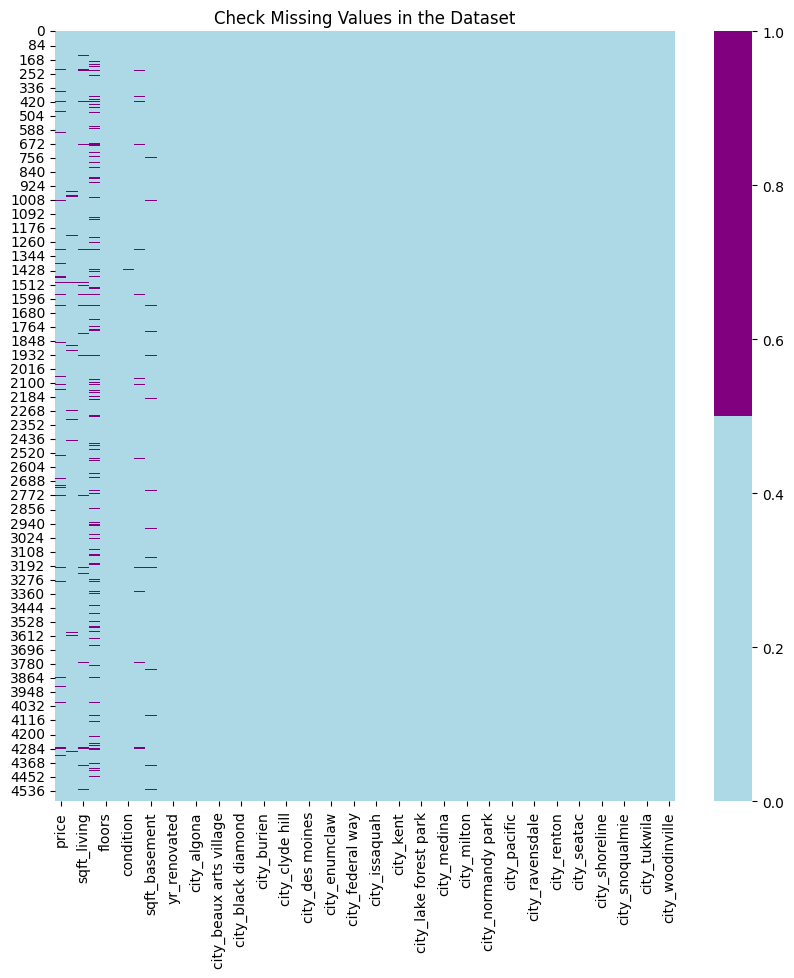

Mean: {'price': 551962.9884732141, 'floors': 1.5120652173913043, 'bedrooms': 3.4008695652173913, 'sqft_living': 2139.3469565217392, 'sqft_lot': 14852.516086956522, 'condition': 3.4517391304347824, 'sqft_above': 1827.2654347826087, 'sqft_basement': 312.08152173913044, 'yr_built': 1970.786304347826, 'yr_renovated': 808.6082608695652}
Std: {'price': 563834.7025471414, 'floors': 0.5382883772969885, 'bedrooms': 0.9088481155258186, 'sqft_living': 963.2069157608643, 'sqft_lot': 35884.43614480966, 'condition': 0.6772297675592746, 'sqft_above': 862.1689769625976, 'sqft_basement': 464.1372280666067, 'yr_built': 29.73184839009964, 'yr_renovated': 979.4145364007455}


In [270]:
data = pd.read_csv('data.csv')

#removing null values
data = data.dropna()


#segragating numeric and string data type columns 
numeric_columns= [ 'price', 'floors','bedrooms', 'sqft_living', 'sqft_lot' ,'condition', 'sqft_above', 
                  'sqft_basement', 'yr_built','yr_renovated']
categorical_columns= ['street', 'city']

#normalizing numeric data 

mean = data[numeric_columns].mean().to_dict()
std = data[numeric_columns].std().to_dict()

with open('mean_std.json', 'w') as f:
    json.dump({'mean': mean, 'std': std}, f)

data[numeric_columns] = (data[numeric_columns] - data[numeric_columns].mean()) / data[numeric_columns].std()

#removing outliers
for column in numeric_columns:
    q1, q3 = np.percentile(data[column], [25, 75])
    iqr= q3-q1
    lower_bound= q1 -1.5*iqr
    upper_bound= q3+ 1.5*iqr
    data[column] = np.where((data[column] < lower_bound) | (data[column] > upper_bound), np.nan, data[column])

#standarizing string data type columns 
for col in categorical_columns:
    data[col] = data[col].astype(str).str.lower().str.strip()
    data[col] = data[col].replace(to_replace=r'[^a-zA-Z0-9\s]', value='', regex=True)

#one hot encoding
data = pd.get_dummies(data, columns = ['city'])

cols = data.columns[:55] 
colours = ['#ADD8E6', '#800080'] 
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours),ax=ax)
plt.title("Check Missing Values in the Dataset")
plt.show()
print('Mean:', mean)
print('Std:', std)

### Null values, Duplicates , Redundant Data

In [271]:
warnings.simplefilter(action='ignore', category=FutureWarning)

#filling null values with mean 
data = data.fillna(data.mean())

for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    # print('{} - {}%'.format(col, round(pct_missing*100)))

#dropping duplicates 
data.drop_duplicates()

#reseting the index 
data.reset_index(drop=True)

#dropping unnecessary columns 
data= data.drop('view', axis=1)
data= data.drop('street', axis=1)

#saving the  cleansed dataset
data.to_csv('data_cleaned.csv', index= False)

data.head()

,price,bedrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,yr_renovated,...,city_seatac,city_seattle,city_shoreline,city_skykomish,city_snoqualmie,city_snoqualmie pass,city_tukwila,city_vashon,city_woodinville,city_yarrow point
0,-0.423817,-0.441074,-0.829881,-0.193413,-0.022414,-0.667040,-0.565162,-0.672391,-0.530956,1.221538,...,0,0,1,0,0,0,0,0,0,0
1,-0.124122,1.759513,1.568358,-0.161700,0.906456,2.286168,1.789365,-0.069121,-1.674511,-0.825604,...,0,1,0,0,0,0,0,0,0,0
2,-0.372384,-0.441074,-0.217344,-0.080969,-0.951284,0.809564,0.119158,-0.672391,-0.160982,-0.825604,...,0,0,0,0,0,0,0,0,0,0
3,-0.234046,-0.441074,-0.144670,-0.190125,-0.951284,0.809564,-0.959517,1.482145,-0.261884,-0.825604,...,0,0,0,0,0,0,0,0,0,0
4,-0.003481,0.659220,-0.206962,-0.121293,-0.951284,0.809564,-0.797135,1.051238,0.175357,1.208264,...,0,0,0,0,0,0,0,0,0,0


## Gathering Data Information

In [241]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   price                    4600 non-null   float64
 1   bedrooms                 4600 non-null   float64
 2   sqft_living              4600 non-null   float64
 3   sqft_lot                 4600 non-null   float64
 4   floors                   4600 non-null   float64
 5   condition                4600 non-null   float64
 6   sqft_above               4600 non-null   float64
 7   sqft_basement            4600 non-null   float64
 8   yr_built                 4600 non-null   float64
 9   yr_renovated             4600 non-null   float64
 10  city_algona              4600 non-null   uint8  
 11  city_auburn              4600 non-null   uint8  
 12  city_beaux arts village  4600 non-null   uint8  
 13  city_bellevue            4600 non-null   uint8  
 14  city_black diamond      

## Visualizing data Information

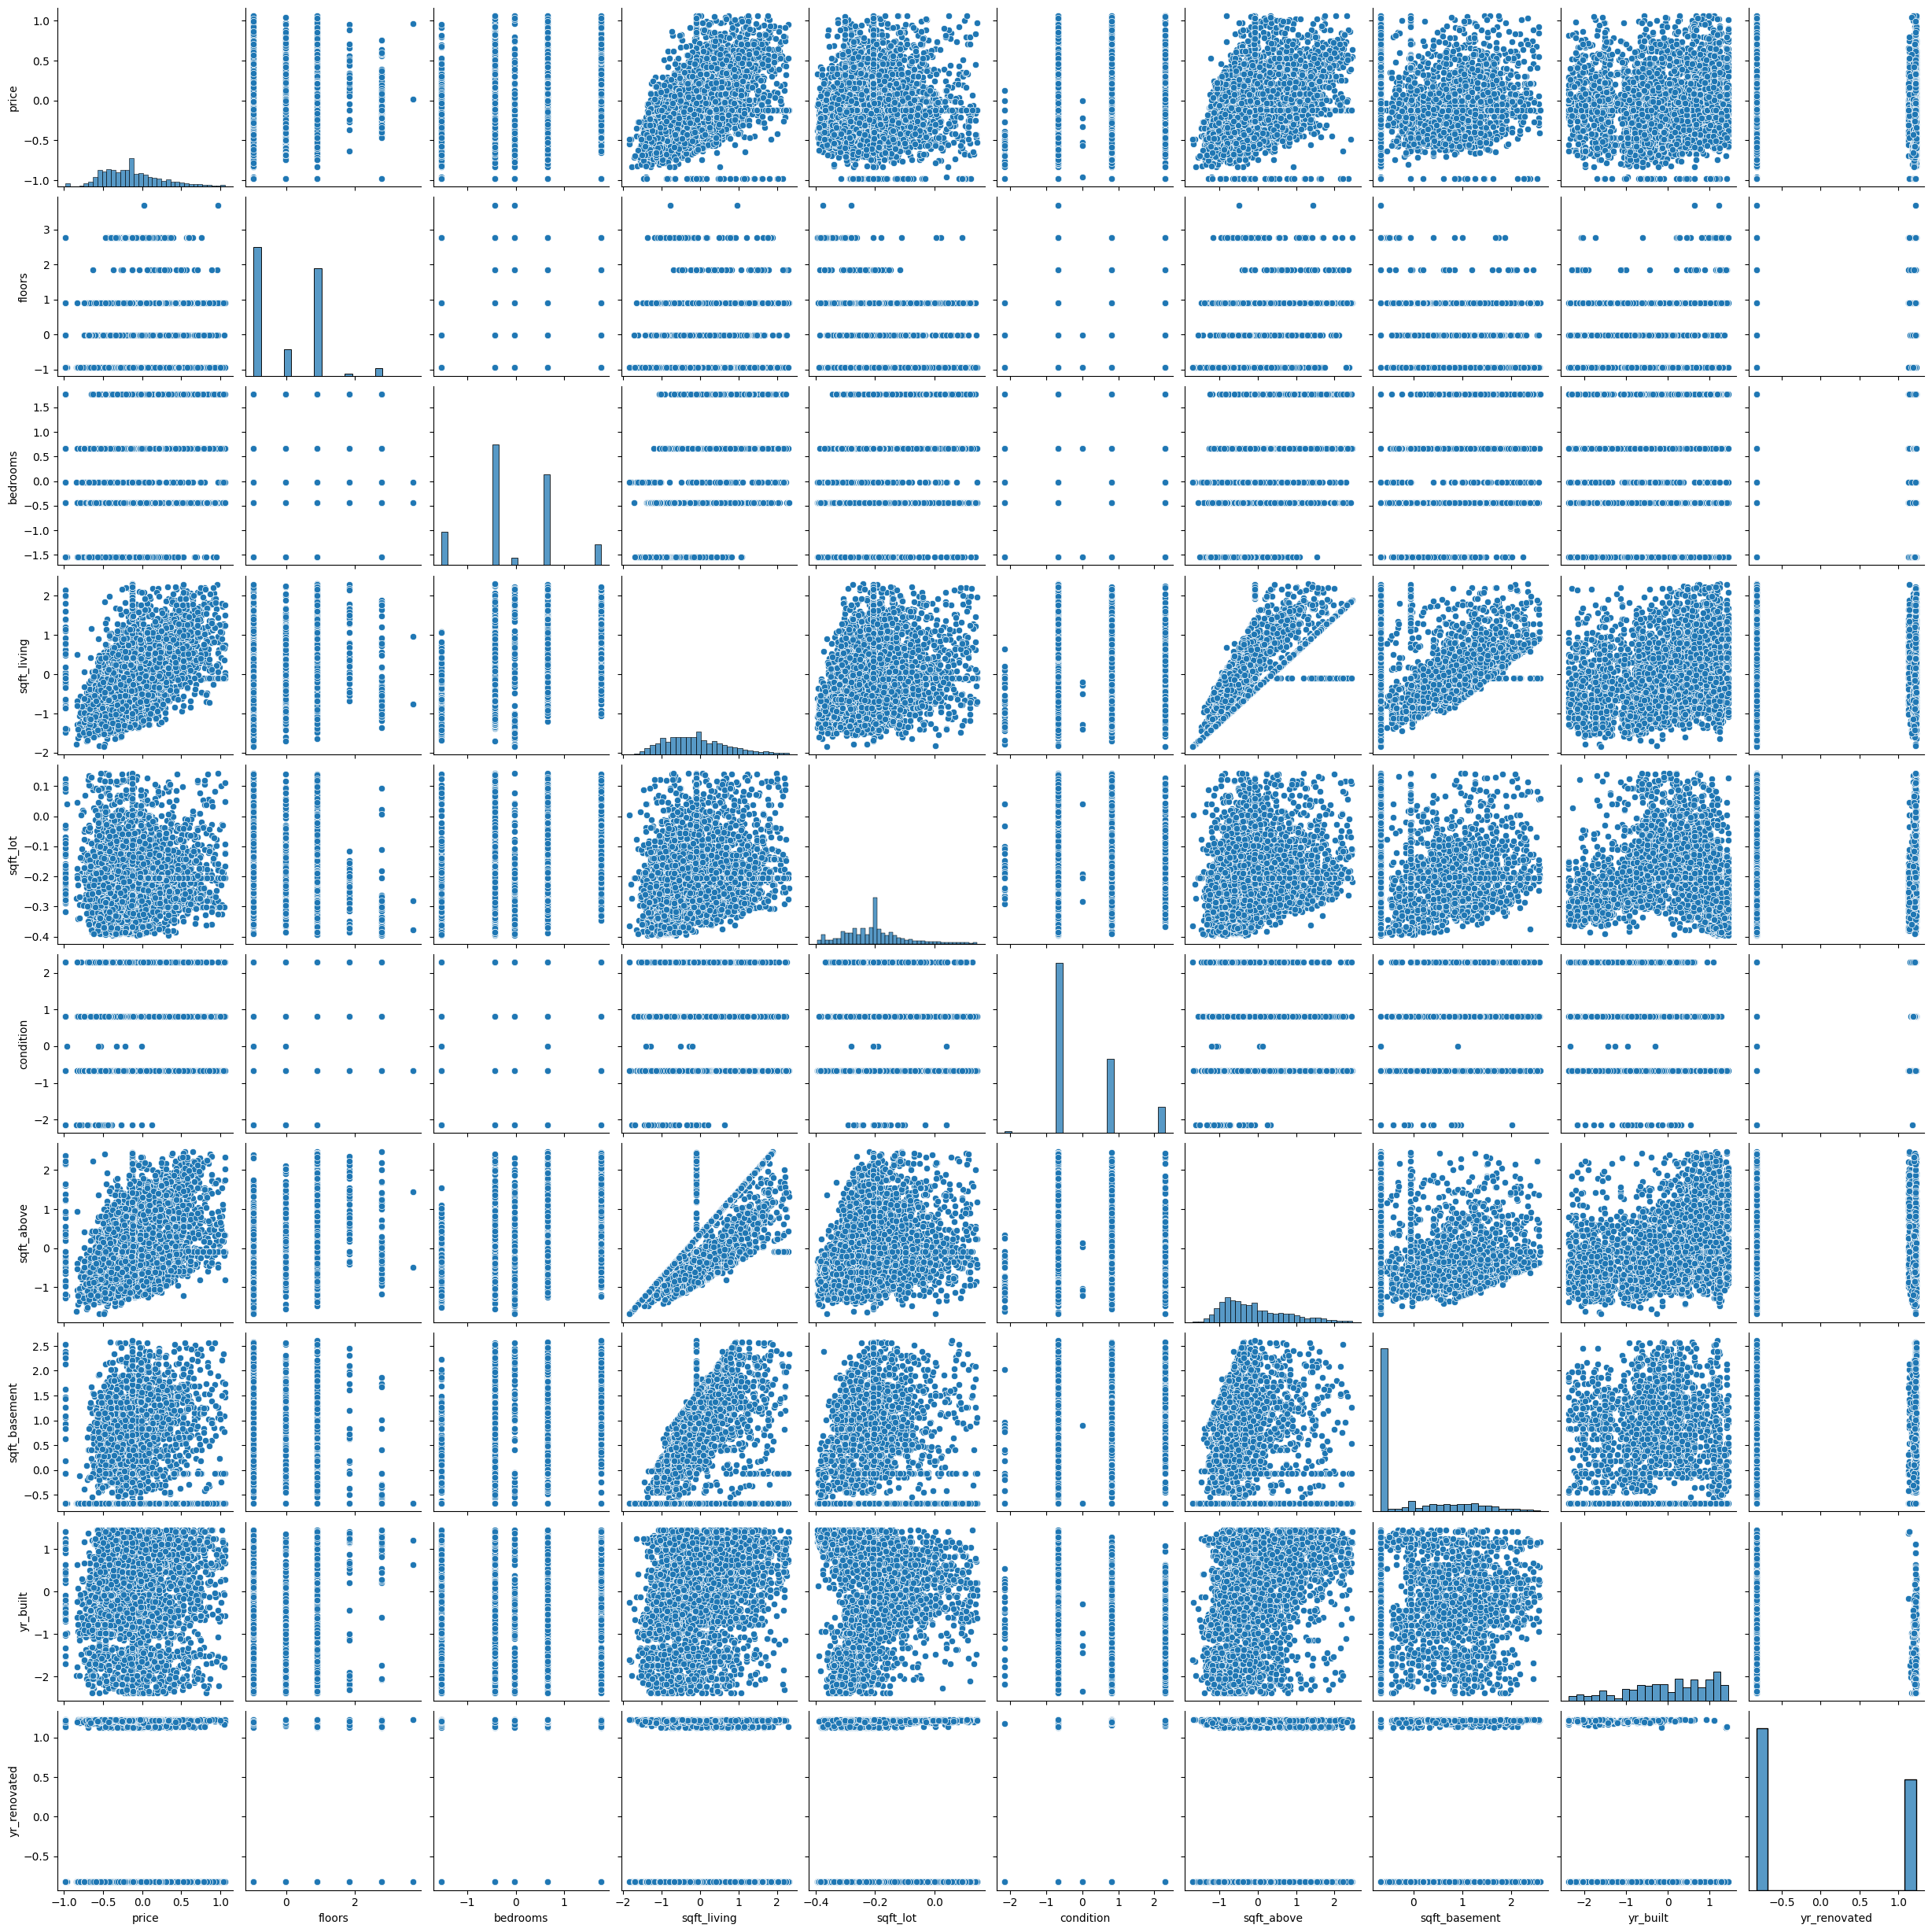

In [5]:
sns.pairplot(data[numeric_columns])
plt.show()

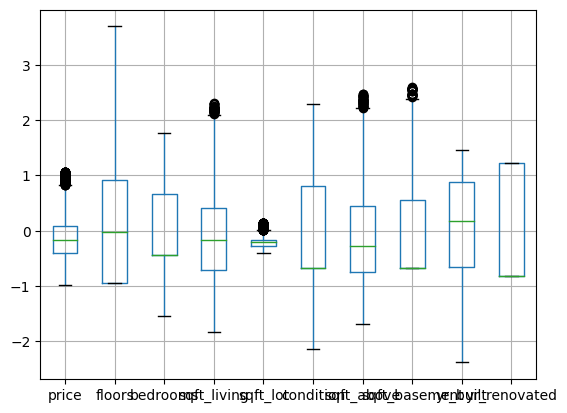

In [6]:
data.boxplot(numeric_columns)
plt.show()

## Data Analysis 

### Correlation Analysis 

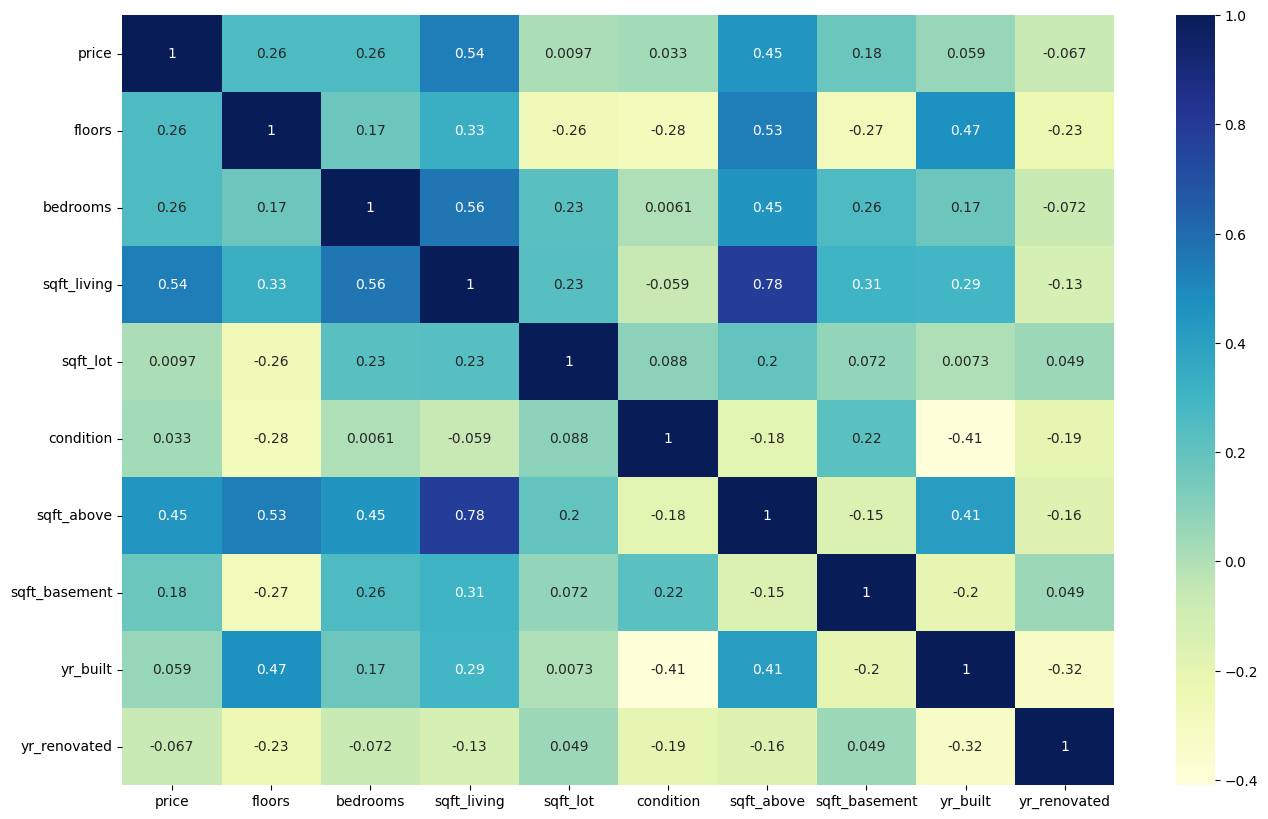

In [7]:
# analyzing correlation 
scaler = MinMaxScaler()

numeric_columns= [ 'price', 'floors','bedrooms', 'sqft_living', 'sqft_lot' ,'condition', 'sqft_above', 
                  'sqft_basement', 'yr_built','yr_renovated']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
plt.figure(figsize = (16, 10))
sns.heatmap(data[numeric_columns].corr(), annot = True, cmap="YlGnBu")
plt.show()

In [256]:
corr_matrix = data.corr()
corr_matrix['price'].sort_values(ascending=True)

city_kent                 -0.175091
city_auburn               -0.169702
city_federal way          -0.163157
city_renton               -0.127504
city_covington            -0.102134
city_maple valley         -0.098959
city_des moines           -0.093170
city_seatac               -0.087824
city_tukwila              -0.085279
city_burien               -0.079242
yr_renovated              -0.066721
city_shoreline            -0.064981
city_enumclaw             -0.063566
city_pacific              -0.043224
city_algona               -0.042212
city_north bend           -0.040246
city_duvall               -0.034873
city_skykomish            -0.029630
city_black diamond        -0.029366
city_kenmore              -0.019382
city_milton               -0.019138
city_lake forest park     -0.013862
city_carnation            -0.008940
city_normandy park        -0.006178
city_medina               -0.006095
city_inglewoodfinn hill   -0.003914
city_vashon               -0.003496
city_bothell              -0

## Spilliting and Scaling the data 

In [272]:
label = data['price']
features = data.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## L1 Regularization

In [235]:
# lasso = Lasso(alpha=0.001, fit_intercept=True)
# lasso.fit(X_train, y_train)
# lasso.coef_

# y_pred = lasso.predict(X_test_scaled)

# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Mean Absolute Error: {mae:.2f}')
# print(f'Root Mean Squared Error: {rmse:.2f}')
# print('Mean Squared Error:', mse)

# accuracy = lasso.score(X_test, y_test)
# print(accuracy)
# "Accuracy: {}%".format(int((accuracy * 100)))


### L2 Regularization

In [275]:
#using L2 regularization since it gives relatively better results 

ridge = Ridge(alpha=10)
# Train the model
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)

## Evaluation

In [276]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R2 Score: {r2:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print('Mean Squared Error:', mse)

R2 Score: 0.46
Mean Absolute Error: 0.19
Root Mean Squared Error: 0.27
Mean Squared Error: 0.07342418558628863


## Saving the Model

In [274]:
joblib.dump(ridge, 'model.pkl')

['model.pkl']